In [4]:
import os
from glob import glob

from scipy.stats import spearmanr, pearsonr, gaussian_kde
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import sqlite3 as lite

In [5]:
plt.rcParams["font.family"] = "Arial Narrow"

In [6]:
colors = {
    '0h'  : "#fde725", 
    '1h'  : "#37b578",
    '4h'  : "#21908d",
    '7h'  : "#31668d",
    '10h' : "#43377f",
    '24h' : "#440154",
    'w24h': '#fb8524',
#     'w48h': '#00000080',
}

# Load compartments

In [7]:
treatments = ['NUT']
conditions = ['WT']
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h'] #, 'w48h']
replicates = ['1', '2']

In [9]:
db_path = '../../data/ComplementaryData/HiC/TADbit_results/'

#### Define which Eigenvector to use according to manual curation

In [10]:
which_ev = {
    ('0h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('0h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w24h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    },
    ('w24h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    },
    ('w48h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    },
    ('w48h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    }
}

In [11]:
hashs = {}
wjobids = {}
samples = []
for rep in replicates:
    hashs[rep] = {}
    wjobids[rep] = {}
    for treatment in treatments:
        for condition in conditions:
            for time in times:
                sample = condition, treatment, time
                try:
                    con = lite.connect(os.path.join(
                        db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}_TR{rep}/trace.db'))
                except lite.OperationalError:
                    print(f'Error {sample}')
                    print(os.path.join(
                        db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}_TR{rep}/trace.db'))
                    continue
                hashs[rep][sample] = {}
                wjobids[rep][sample] = {}
                samples.append(sample)
                cur = con.cursor()
                cur.execute("""
                select distinct Id, Parameters, Parameters_md5 from JOBs
                where Type = 'Segment' AND parameters like '%compartments:1%' AND not parameters like '%crms:[chrY]%'
                """)
                jobids = cur.fetchall()
                for jobid, parameters, md5 in jobids:
                    c = parameters.split('crms:[')[1].split(']')[0]
                    ev_index = which_ev[time,rep].get(c, 1)
                    if ev_index == 1:
                        test_ev = lambda x: 'ev_index:[2]' not in x
                    else:
                        test_ev = lambda x: 'ev_index:[2]' in x
                    if test_ev(parameters):
                        hashs[rep][sample][c] = md5
                        wjobids[rep][sample][c] = jobid
                con.close()
                con = lite.connect(os.path.join(
                    db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}_TR{rep}/trace.db'))
                cur = con.cursor()
                cur.execute("""
                select distinct JOBid, richA_corr from SEGMENT_OUTPUTs where Resolution = 100000 and Chromosome != "chrY"
                """)
                jobids = dict(cur.fetchall())
                for c in wjobids[rep][sample]:
                    wjobids[rep][sample][c] = abs(
                        jobids[wjobids[rep][sample][c]])
                con.close()


In [12]:
for r in hashs:
    for t in hashs[r]:
        print('{}\t{}\t{}'.format(r, t, len(hashs[r][t])))

1	('WT', 'NUT', '0h')	23
1	('WT', 'NUT', '1h')	23
1	('WT', 'NUT', '4h')	23
1	('WT', 'NUT', '7h')	23
1	('WT', 'NUT', '10h')	23
1	('WT', 'NUT', '24h')	23
1	('WT', 'NUT', 'w24h')	23
2	('WT', 'NUT', '0h')	23
2	('WT', 'NUT', '1h')	23
2	('WT', 'NUT', '4h')	23
2	('WT', 'NUT', '7h')	23
2	('WT', 'NUT', '10h')	23
2	('WT', 'NUT', '24h')	23
2	('WT', 'NUT', 'w24h')	23


In [13]:
cpath = os.path.join(
    db_path, 
    'Cabrera_2022_HCT116_{}_{}_{}_TR{}/06_segmentation/compartments_100kb/{}_EigVect{}_{}.tsv')

In [14]:
chromosomes = [f'chr{c}' for c in list(range(1, 23)) + ['X']]

In [17]:
h = 'hash'
evs = {}
for rep in hashs:
    evs[rep] = {}
    for params in hashs[rep]:
        time = params[-1]
        evs[rep][params] = {}
        for c in chromosomes:
            evs[rep][params][c] = {}
            nev = which_ev[time, rep].get(c, 1)
            try:
                fh = open(cpath.format(*params, rep, c, nev, hashs[rep][params][c]))
            except KeyError:
                print('MISSING:', params, nev, c)
                continue
            next(fh)
            for nl, line in enumerate(fh):
                ev = line.split('\t')[nev - 1]
                evs[rep][params][c][nl] = float(ev)

## put all into dataframe

In [18]:
headers = []
values = []
for rep in hashs:
    for params in hashs[rep]:
        headers.append("{}:{}-{} TR{}".format(*params, rep))
        values.append([v for c in chromosomes for v in evs[rep][params][c].values()])

In [19]:
compartments = pd.DataFrame(np.asarray(values).T, columns=headers)

In [20]:
compartments = compartments.dropna()

In [21]:
norm_compartments = StandardScaler().fit_transform(compartments).T

In [22]:
pca = PCA(n_components=2)

In [23]:
pca_result = pca.fit_transform(norm_compartments)

In [24]:
pca_result

array([[ -9.37666992,  13.06962491],
       [-21.91762124, -15.37431193],
       [-17.91197739,  -8.77539261],
       [-16.39936032,  -5.18299067],
       [  3.72958324,  17.50792252],
       [ 11.79542837,  10.83557582],
       [ 54.11951761, -12.39300337],
       [ -8.51326003,  11.31207059],
       [-22.60459072, -15.02518419],
       [-19.61576964,  -8.69135099],
       [-18.6333723 ,  -7.45897459],
       [ -0.4125369 ,  21.28985542],
       [ 11.1624045 ,  10.64680844],
       [ 54.57822474, -11.76064934]])

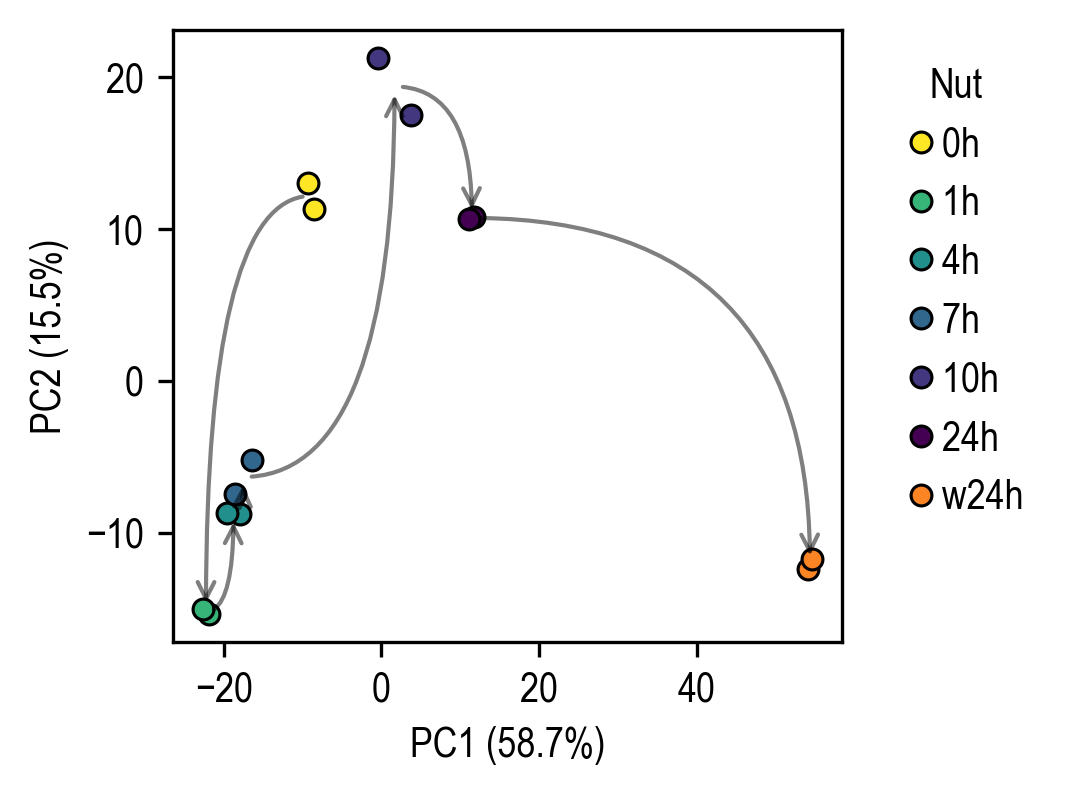

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_compartments)

plt.figure(figsize=(3.7, 2.75), dpi=300)
axe1 = plt.subplot(1, 1, 1)

N = len(headers) // 2

Xs = []
Ys = []
for n, (x, y, _) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=5, label=headers[n][:-3].split("-")[-1], 
                  mec='k', markeredgewidth=0.75)
    else:
        axe1.plot(x, y, 'o', color=color, ms=5, mec='k', markeredgewidth=0.75)
    Xs.append(x)
    Ys.append(y)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=1, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title='Nut',
           handletextpad=-0.5)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
# plt.savefig("compartments_PCA1vs2_w24h.pdf", filetype="pdf", dpi=300)
# plt.savefig("compartments_PCA1vs2_w24h.png", filetype="png", dpi=300)


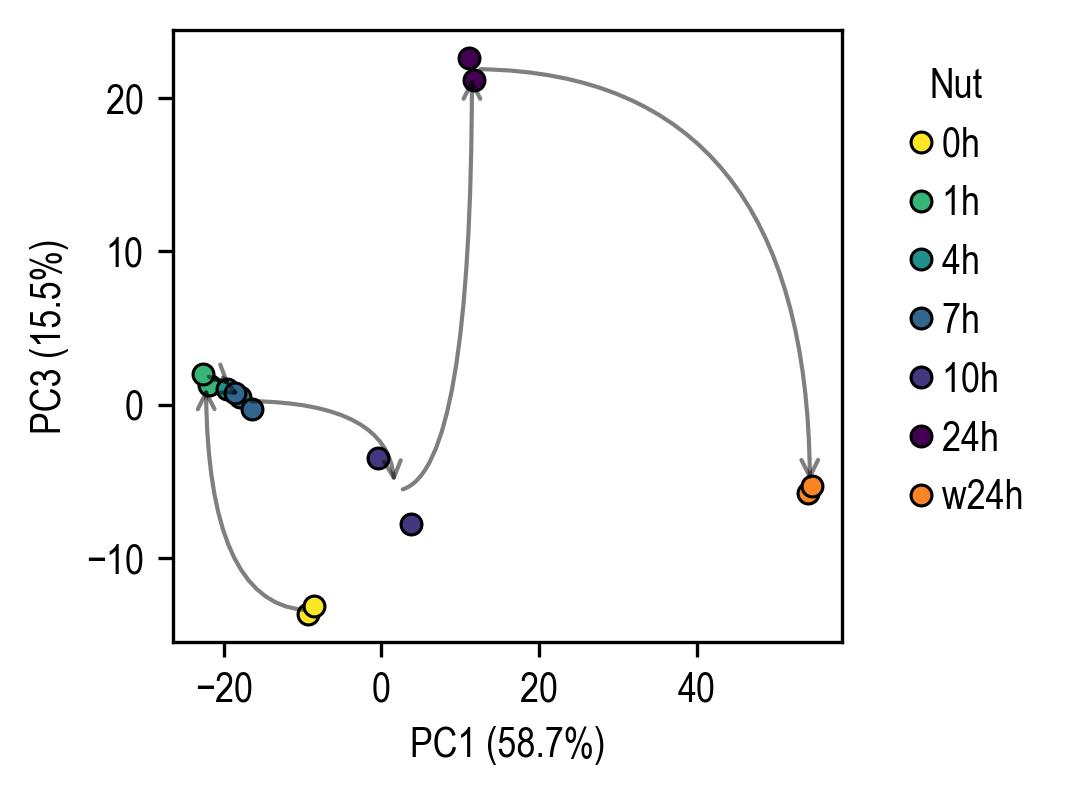

In [28]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_compartments)


plt.figure(figsize=(3.7, 2.75), dpi=300)
axe1 = plt.subplot(1, 1, 1)

N = len(headers) // 2

Xs = []
Ys = []
for n, (x, _, y) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=5, label=headers[n][:-3].split("-")[-1], 
                  mec='k', markeredgewidth=0.75)
    else:
        axe1.plot(x, y, 'o', color=color, ms=5, mec='k', markeredgewidth=0.75)
    Xs.append(x)
    Ys.append(y)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=1, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title='Nut',
           handletextpad=-0.5)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
# plt.savefig("Suppl_compartments_PCA1vs3_w24h.pdf", filetype="pdf", dpi=300)
# plt.savefig("Suppl_compartments_PCA1vs3_w24h.png", filetype="png", dpi=300)

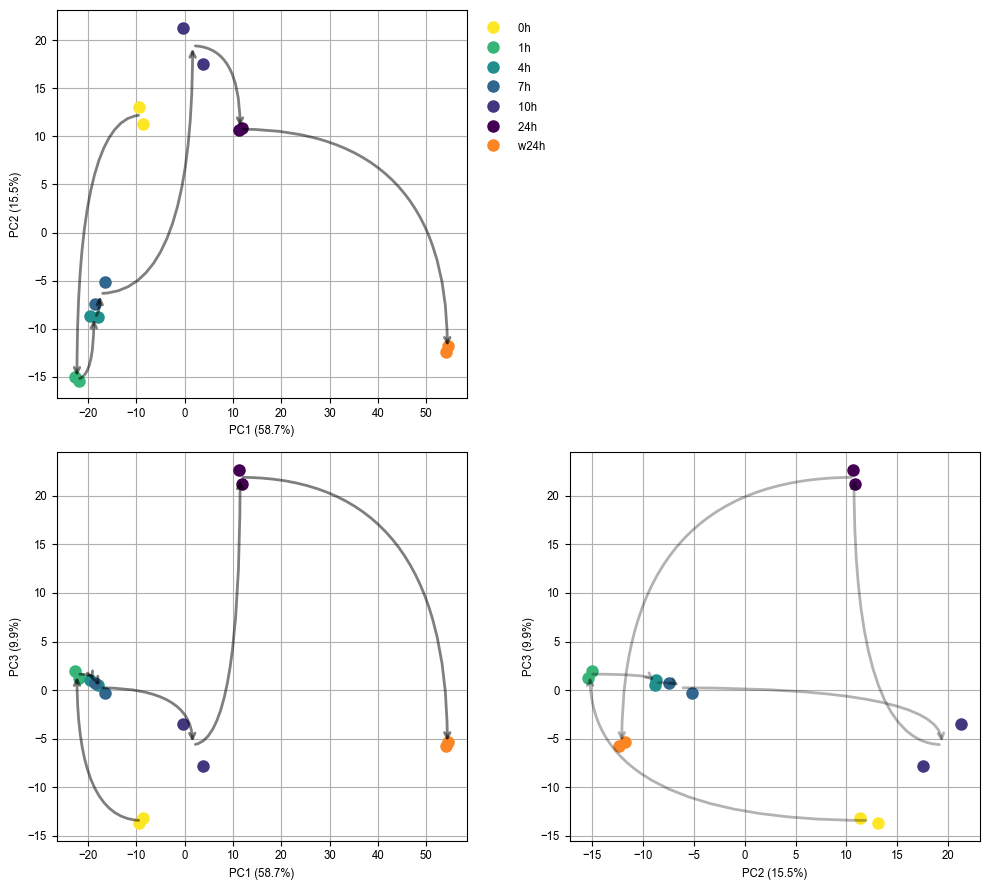

In [29]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_compartments)

plt.figure(figsize=(10, 9))
axe1 = plt.subplot(2, 2, 1)
axe2 = plt.subplot(2, 2, 3)
axe3 = plt.subplot(2, 2, 4)

N = len(headers) // 2

Xs = []
Ys = []
Zs = []
for n, (x, y, z) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=8, label=headers[n][:-3].split("-")[-1])
    else:
        axe1.plot(x, y, 'o', color=color, ms=8)
    axe2.plot(x, z, 'o', color=color, ms=8)
    axe3.plot(y, z, 'o', color=color, ms=8)
    Xs.append(x)
    Ys.append(y)
    Zs.append(z)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
prevz = (Zs[0] + Zs[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    avz = (Zs[i] + Zs[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    axe2.annotate(xy=(prevx, prevz), xycoords='data', textcoords='data', xytext=(avx, avz), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    axe3.annotate(xy=(prevy, prevz), xycoords='data', textcoords='data', xytext=(avy, avz), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.3,
                                  connectionstyle="angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    prevz = avz
    
axe1.grid()
axe2.grid()
axe3.grid()
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axe2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe2.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
axe3.set_xlabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axe3.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
plt.tight_layout()
# plt.savefig("Suppl_compartments_PCA1vs2vs3_w24h.pdf", filetype="pdf", dpi=300)
# plt.savefig("Suppl_compartments_PCA1vs2vs3_w24h.png", filetype="png", dpi=300)

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.lines import Line2D

In [31]:
pca.explained_variance_ratio_

array([0.58721372, 0.15451021, 0.09899757])

In [32]:
pca = PCA(n_components=12)
pca_result = pca.fit_transform(norm_compartments)

dmatrix = np.zeros((len(pca_result), len(pca_result)))
print(sum(pca.explained_variance_ratio_))
for n, w in enumerate(pca.explained_variance_ratio_):
    for i, v1 in enumerate(pca_result[:,n]):
        for j, v2 in enumerate(pca_result[:,n]):
            dmatrix[i][j] += (v2 - v1)**2 * w

dmatrix = dmatrix**0.5

Z = linkage(dmatrix, 'ward', optimal_ordering=True)

0.9904390550059123


/tmp/ipykernel_84733/625800189.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dmatrix, 'ward', optimal_ordering=True)


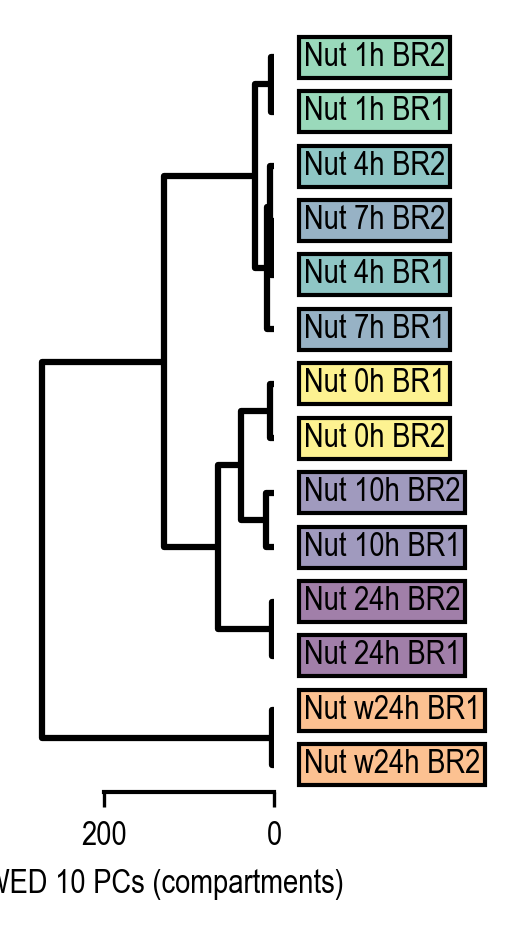

In [34]:
fig = plt.figure(figsize=(1.8, 3.2), dpi=300)
axe = plt.subplot()
axe.set_frame_on(False)
dn = dendrogram(Z, link_color_func=lambda k: 'k', orientation='left')
axe.set_yticklabels([headers[v][3:].replace('-', ' ').replace('UT', 'ut').replace('TR', 'BR') for v in dn['leaves']],
                    rotation=0, size=8)
line = plt.Line2D((axe.get_xticks()[0], axe.get_xticks()[-2]),
                          [0, 0], color='k', lw=1)
line.set_clip_on(False)
axe.add_artist(line)

for n, i in enumerate(dn['leaves']):
    h = headers[i]
    c = [int(colors[h.split('-')[1].split()[0]][1:][i:i+2], 16) / 256 for i in (0, 2, 4)]
    c = tuple(c + [0.5])
    bbox = dict(boxstyle="square", ec=(0, 0, 0, 1), fc=c, 
                alpha=None, pad=0.15)
    plt.setp(axe.get_yticklabels()[n], bbox=bbox)
axe.set_yticklabels(axe.get_yticklabels(), va='center')
axe.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("   WED 10 PCs (compartments)", size=8, ha = 'center')
plt.tight_layout()
# plt.savefig("compartments_clustering_10PCs_w24h.pdf", dpi=300)